In [1337]:
from pathlib import Path

## Getting the features training directory
trainDataDir = Path.cwd() / "data_train\\features"
if not trainDataDir.exists():
    raise FileNotFoundError("The " + str(trainDataDir) + " path does not exist") 
if not trainDataDir.is_dir():
    raise FileNotFoundError("The " + str(trainDataDir) + "path is not a directory") 

# Getting the clinical file and read it in a dataframe 
clinicalDataFile = trainDataDir / "clinical_data.csv"
if not clinicalDataFile.exists():
    raise FileNotFoundError("The " + str(clinicalDataFile)+ " file does not exist") 
xClinicalTrain = pd.read_csv(clinicalDataFile)
xClinicalTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
PatientID        300 non-null int64
Histology        280 non-null object
Mstage           300 non-null int64
Nstage           300 non-null int64
SourceDataset    300 non-null object
Tstage           300 non-null int64
age              284 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 16.5+ KB


In [1338]:
## Get variables from the Mstage one 
#(not include the PatientID and the Histology variables)
dataClinical = xClinicalTrain.loc[:,["Mstage","Nstage", "SourceDataset", "Tstage", "age"]]

##Create dummy variables for sorting data into mutually exclusive categories 
dataClinical_dummy = pd.get_dummies(dataClinical, drop_first=True)
dataClinical_dummy.info()

## Replace the null values in the age column with the median value
dataClinical_dummy.age.fillna(value=dataClinical_dummy['age'].median(),inplace=True)
dataClinical_dummy

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
Mstage              300 non-null int64
Nstage              300 non-null int64
Tstage              300 non-null int64
age                 284 non-null float64
SourceDataset_l2    300 non-null uint8
dtypes: float64(1), int64(3), uint8(1)
memory usage: 9.8 KB


,Mstage,Nstage,Tstage,age,SourceDataset_l2
0,0,0,2,66.0000,1
1,0,2,4,64.5722,0
2,0,3,2,66.0452,0
3,0,2,3,59.3566,0
4,0,3,4,71.0554,0
...,...,...,...,...,...
295,0,0,1,87.1266,0
296,0,0,1,69.9473,0
297,0,1,3,59.8439,0
298,0,0,1,70.0000,1


In [1339]:
##Getting the output training file and read it to the yTrain dataframe
outputFile = trainDataDir.parent / "output_VSVxRFU.csv"
if not outputFile.exists():
        raise FileNotFoundError("the " + str(outputFile) + " path is not a file") 

yTrain = pd.read_csv(outputFile)
yTrain.info()
## Dropping the PatientID variable because we do not need to evaluate its impact
yTrain.drop(["PatientID"], axis=1, inplace=True)
yTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
PatientID       300 non-null int64
SurvivalTime    300 non-null int64
Event           300 non-null int64
dtypes: int64(3)
memory usage: 7.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
SurvivalTime    300 non-null int64
Event           300 non-null int64
dtypes: int64(2)
memory usage: 4.8 KB


In [1340]:
#Merge yTrain frame with dataClinical_dummy frame
clinicalYMerged = pd.concat([yTrain, dataClinical_dummy], axis=1).reindex(yTrain.index)
clinicalYMerged


,SurvivalTime,Event,Mstage,Nstage,Tstage,age,SourceDataset_l2
0,1378,0,0,0,2,66.0000,1
1,379,1,0,2,4,64.5722,0
2,573,1,0,3,2,66.0452,0
3,959,0,0,2,3,59.3566,0
4,2119,0,0,3,4,71.0554,0
...,...,...,...,...,...,...,...
295,1540,0,0,0,1,87.1266,0
296,946,0,0,0,1,69.9473,0
297,559,0,0,1,3,59.8439,0
298,1952,0,0,0,1,70.0000,1


# Survival analysis 
Use of the lifeline api from Python module to perform a Cox’s proportional hazard model  

**Why this one ?**   
This allows us to model survival times with censored data.  
We can try to link an event (modeled by a date) to a certain number of explanatory variables.

## Compute the Cox model 

We start by computing univariate Cox analyses for all these variables to describe how each one separately impact the survival time.
### Univariate Cox regression

In [1341]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()

# Univariate coxph function to multiple covariates at once
# for each variable whitout include the first three variables.
for col in clinicalYMerged.columns[2:7]:
    cph.fit(clinicalYMerged[[col, 'SurvivalTime', 'Event']], 'SurvivalTime', 'Event')
    print(cph.summary)

            coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
Mstage  0.464258   1.590834  0.188348        0.095103        0.833413   

        exp(coef) lower 95%  exp(coef) upper 95%         z         p  -log2(p)  
Mstage             1.099772              2.30116  2.464897  0.013705  6.189126  
            coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
Nstage  0.331322   1.392808  0.066416         0.20115        0.461494   

        exp(coef) lower 95%  exp(coef) upper 95%         z             p  \
Nstage             1.222808             1.586443  4.988608  6.081601e-07   

         -log2(p)  
Nstage  20.649046  
            coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
Tstage  0.239801   1.270996  0.067834        0.106849        0.372752   

        exp(coef) lower 95%  exp(coef) upper 95%         z         p  \
Tstage             1.112767             1.451725  3.535132  0.000408   

         -log2(p)  
Tstage  11.260658  
         coef  exp(

#### Data analysis 

The output above show the regression coefficient (**coef**) corresponding to the meaning of the hazard. The hazard ratio (**exp(coeff)**) gives the effect size of the covariate.
The Confidence intervals of the hazard ratios - (**exp(coef) lower 95% - exp(coef) upper 95%**), and the **p-value** are for the statistical significance in relation to overall survival.

From this summary above, we can deduce that all the variables -**Mstage**, **Nstage**, **Tstage** and **age**- has a positive coefficient except the **dataset source**. Thus, higher stages and older age are associated with pooreer survival and those factors increase the probability of occurrence of the event because of their HR > 1.
The origin dataset have a negative coefficient that means individual treated where the data L1 came from have a better risk of survival than those from L2. With a HR < 1, this factor decrease the probability of occurrence of the event.

But, the **age** variable have lower statistically significant coefficients (IC 95% include 1 and its p-value > 0.05) while the others have not.

That's why, we will exclude this variable to fit the multivariate cox analysis to understand how the factors jointly impact on survival

### Multivariate Cox regression analysis

In [1342]:
## Dropping the age variable from the covariables data
clinicalYMerged.drop(["age"], axis=1, inplace = True)

cph.fit(clinicalYMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)

#### Data analysis

Jointly, those covariates still have the same hypothesis. However having a different p-value, we can conclude that the **SourceDataset** covariable have a high statically significant coefficient.
The others exceed the threshold of 5%, but as the **Nstage** had a p-value much less important than others and also because separately, its p-value was **< 0.000005**, I suggest to refit the cox modele only on the **Nstage** and **SourceDataset_l2** jointly and see if the p-value's Nstage decrease.

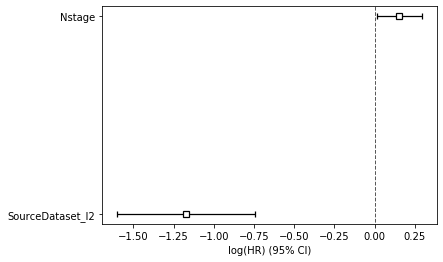

In [1343]:
##Refit the model by keeping only the Nstage and SourceDataset_l2 covariables
clinicalYMerged.drop(["Mstage", "Tstage"], axis=1, inplace=True)
cph.fit(clinicalYMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)

ax = cph.plot()

#### Data analysis
As we can read, the Nstage and SourceDataset jointly have highly statistically significant coefficients.
The Nstage covariable have positive coefficient and an HR > 1, that mean an higher Nstage is associated with pooreer survival and this factor increase the probability of occurrence of the event.
On the other side, being treated from the structure where lung1 source individuals were can reduce the risk of event and be a good prognostic factor.

Now, let's add the radiomics variables to those 2 clinical variables, and analyse jointly their impact on survival time.

In [1344]:
# Getting the radiomic file and read it in a dataframe 
radiomicsFile = trainDataDir / "radiomics.csv"
if not radiomicsFile.exists():
    raise FileNotFoundError("The " + str(radiomicsFile)+ " file does not exist") 
xRadiomicsTrain = pd.read_csv(radiomicsFile)
xRadiomicsTrain.info()
xRadiomicsTrain.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 54 columns):
Unnamed: 0       301 non-null object
shape            301 non-null object
shape.1          301 non-null object
shape.2          301 non-null object
shape.3          301 non-null object
shape.4          301 non-null object
shape.5          301 non-null object
shape.6          301 non-null object
shape.7          301 non-null object
firstorder       301 non-null object
firstorder.1     301 non-null object
firstorder.2     301 non-null object
firstorder.3     301 non-null object
firstorder.4     301 non-null object
firstorder.5     301 non-null object
firstorder.6     301 non-null object
firstorder.7     301 non-null object
firstorder.8     301 non-null object
firstorder.9     301 non-null object
firstorder.10    301 non-null object
firstorder.11    301 non-null object
firstorder.12    301 non-null object
firstorder.13    301 non-null object
textural         301 non-null object
textura

,Unnamed: 0,shape,shape.1,shape.2,shape.3,shape.4,shape.5,shape.6,shape.7,firstorder,...,textural.21,textural.22,textural.23,textural.24,textural.25,textural.26,textural.27,textural.28,textural.29,textural.30
0,NaN,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
1,PatientID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,202,0.027815034276150445,0.274891584789629,48.55924216871593,1.5379640537333283,0.650210255286885,5431.333209994288,0.2752277631406584,19786.0,3942944085.0,...,1.4579804820599591,555.3785937091678,14592.30372702833,0.8913295337029291,0.003561530161295479,954.7491354587909,0.00338435209269195,851.9873727726894,0.0044435855454578775,1651.7107610742885
3,371,0.023015490265467994,0.18821000537331142,75.70336848516055,1.744961158341729,0.5730786586392099,10369.568728926952,0.240726823947402,43168.0,3122890068.0,...,2.5121246601768097,1766.6193730958223,22881.93268598017,0.7660321748303586,0.002246203831804831,1092.8237238353574,0.0020694221485567173,884.838627165461,0.0036327469226913886,3386.995589481547
4,246,0.02734810613893409,0.26573989535056836,70.43436661176133,1.5554202430337098,0.6429130676926181,10558.818691399667,0.20076598812381322,52655.0,1059535256.0,...,4.096837887896892,3462.816343789217,18773.106002343673,0.6445541733928403,0.0018803220646738058,878.9896008279054,0.0016345955500716887,634.9100359203011,0.00486911711499068,4232.41808034498


We can see that the data are not well structured, so we must to make it suitable as we will fusion with the output training data and than with the clinical dataframe.
We will remove the non needed columns as **Unnamed:0** which contains the PatientID list and we will use the first row as column's names.

In [1345]:
xRadiomicsTrain.drop(["Unnamed: 0"], axis=1, inplace=True)
xRadiomicsTrain.head()
firstRow = xRadiomicsTrain.loc[0,:]
xRadiomicsTrain.columns = firstRow

xRadiomicsTrain.drop([0,1], inplace=True)
xRadiomicsTrain.reset_index(drop=True,inplace=True)
xRadiomicsTrain.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,0.027815034276150445,0.274891584789629,48.55924216871593,1.5379640537333283,0.650210255286885,5431.333209994288,0.2752277631406584,19786.0,3942944085.0,5.138062382118321,...,1.4579804820599591,555.3785937091678,14592.30372702833,0.8913295337029291,0.003561530161295479,954.7491354587909,0.00338435209269195,851.9873727726894,0.0044435855454578775,1651.7107610742885
1,0.023015490265467994,0.18821000537331142,75.70336848516055,1.744961158341729,0.5730786586392099,10369.568728926952,0.240726823947402,43168.0,3122890068.0,4.461053722332744,...,2.5121246601768097,1766.6193730958223,22881.93268598017,0.7660321748303586,0.002246203831804831,1092.8237238353574,0.0020694221485567173,884.838627165461,0.0036327469226913886,3386.995589481547
2,0.02734810613893409,0.26573989535056836,70.43436661176133,1.5554202430337098,0.6429130676926181,10558.818691399667,0.20076598812381322,52655.0,1059535256.0,3.437110589654181,...,4.096837887896892,3462.816343789217,18773.106002343673,0.6445541733928403,0.0018803220646738058,878.9896008279054,0.0016345955500716887,634.9100359203011,0.00486911711499068,4232.41808034498
3,0.026811108023238883,0.2554063972936345,46.8187996428785,1.5761204705010834,0.634469267239501,4221.412123045331,0.3238779820439811,13074.0,658332446.0,4.3525641618756525,...,1.8243276462412692,683.8697916865876,7978.285175929893,0.8281380543886281,0.00285521581708568,907.0459291041462,0.0026795331834220766,774.8853866820536,0.003900898967927439,1844.746046182932
4,0.02369124102797724,0.19942420455106544,53.79591062525106,1.7116200972821958,0.5842417961718578,5295.900331416721,0.3272407286073298,16237.0,807253170.0,4.055700408847022,...,2.6525799815994477,962.0947604240029,7520.054910032022,0.7348979775536406,0.006709923144392347,1513.4204452600534,0.0047041135494313106,1197.1408999024193,0.023272656916216904,4444.272811805174


In [1346]:
#Merge YTrain with xRadiomicsTrain data
radioYMerged = pd.concat([yTrain, xRadiomicsTrain], axis=1)
radioYMerged.head()

,SurvivalTime,Event,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,1378,0,0.027815034276150445,0.274891584789629,48.55924216871593,1.5379640537333283,0.650210255286885,5431.333209994288,0.2752277631406584,19786.0,...,1.4579804820599591,555.3785937091678,14592.30372702833,0.8913295337029291,0.003561530161295479,954.7491354587909,0.00338435209269195,851.9873727726894,0.0044435855454578775,1651.7107610742885
1,379,1,0.023015490265467994,0.18821000537331142,75.70336848516055,1.744961158341729,0.5730786586392099,10369.568728926952,0.240726823947402,43168.0,...,2.5121246601768097,1766.6193730958223,22881.93268598017,0.7660321748303586,0.002246203831804831,1092.8237238353574,0.0020694221485567173,884.838627165461,0.0036327469226913886,3386.995589481547
2,573,1,0.02734810613893409,0.26573989535056836,70.43436661176133,1.5554202430337098,0.6429130676926181,10558.818691399667,0.20076598812381322,52655.0,...,4.096837887896892,3462.816343789217,18773.106002343673,0.6445541733928403,0.0018803220646738058,878.9896008279054,0.0016345955500716887,634.9100359203011,0.00486911711499068,4232.41808034498
3,959,0,0.026811108023238883,0.2554063972936345,46.8187996428785,1.5761204705010834,0.634469267239501,4221.412123045331,0.3238779820439811,13074.0,...,1.8243276462412692,683.8697916865876,7978.285175929893,0.8281380543886281,0.00285521581708568,907.0459291041462,0.0026795331834220766,774.8853866820536,0.003900898967927439,1844.746046182932
4,2119,0,0.02369124102797724,0.19942420455106544,53.79591062525106,1.7116200972821958,0.5842417961718578,5295.900331416721,0.3272407286073298,16237.0,...,2.6525799815994477,962.0947604240029,7520.054910032022,0.7348979775536406,0.006709923144392347,1513.4204452600534,0.0047041135494313106,1197.1408999024193,0.023272656916216904,4444.272811805174


### Univariate Cox regression
As for the clinical data, we would like to know which variable separatly impact on the survival time.


In [1347]:
#Univariate coxph function to multiple covariates at once
#for each col from the original_shape_Compactness1
for col in radioYMerged.columns[2:]: 
    cph.fit(radioYMerged[[col, 'SurvivalTime', 'Event']], 'SurvivalTime', 'Event')
    print(cph.summary)


                                  coef     exp(coef)   se(coef)  \
original_shape_Compactness1 -15.117261  2.720552e-07  12.332315   

                             coef lower 95%  coef upper 95%  \
original_shape_Compactness1      -39.288154        9.053632   

                             exp(coef) lower 95%  exp(coef) upper 95%  \
original_shape_Compactness1         8.657082e-18          8549.533807   

                                    z         p  -log2(p)  
original_shape_Compactness1 -1.225825  0.220265  2.182691  
                                 coef  exp(coef)  se(coef)  coef lower 95%  \
original_shape_Compactness2 -0.967446   0.380052  0.680308       -2.300825   

                             coef upper 95%  exp(coef) lower 95%  \
original_shape_Compactness2        0.365933             0.100176   

                             exp(coef) upper 95%         z         p  -log2(p)  
original_shape_Compactness2             1.441859 -1.422071  0.155006  2.689606  
               

                               coef  exp(coef)  se(coef)  coef lower 95%  \
original_firstorder_Range  0.000523   1.000524  0.000159        0.000211   

                           coef upper 95%  exp(coef) lower 95%  \
original_firstorder_Range        0.000836             1.000211   

                           exp(coef) upper 95%        z         p  -log2(p)  
original_firstorder_Range             1.000836  3.28708  0.001012  9.948115  
                                         coef  exp(coef)  se(coef)  \
original_firstorder_RootMeanSquared -0.003018   0.996986  0.000574   

                                     coef lower 95%  coef upper 95%  \
original_firstorder_RootMeanSquared       -0.004142       -0.001894   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
original_firstorder_RootMeanSquared             0.995866             0.998108   

                                            z             p   -log2(p)  
original_firstorder_RootMeanSquared -5

                     coef  exp(coef)  se(coef)  coef lower 95%  \
original_glcm_Id  3.58842  36.176876  0.529835        2.549962   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
original_glcm_Id        4.626878            12.806618           102.194538   

                         z             p  -log2(p)  
original_glcm_Id  6.772709  1.263933e-11  36.20329  
                       coef  exp(coef)  se(coef)  coef lower 95%  \
original_glcm_Idm  3.092416  22.030244  0.455802        2.199061   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
original_glcm_Idm        3.985771             9.016545            53.826785   

                          z             p   -log2(p)  
original_glcm_Idm  6.784565  1.164371e-11  36.321658  
                        coef  exp(coef)  se(coef)  coef lower 95%  \
original_glcm_Imc1 -7.389683   0.000618  1.226343       -9.793272   

                    coef upper 95%  exp(coef) lower 95%  ex

                                                  coef     exp(coef)  \
original_glrlm_ShortRunLowGrayLevelEmphasis -39.994276  4.272742e-18   

                                              se(coef)  coef lower 95%  \
original_glrlm_ShortRunLowGrayLevelEmphasis  18.499385      -76.252403   

                                             coef upper 95%  \
original_glrlm_ShortRunLowGrayLevelEmphasis       -3.736148   

                                             exp(coef) lower 95%  \
original_glrlm_ShortRunLowGrayLevelEmphasis         7.656001e-34   

                                             exp(coef) upper 95%         z  \
original_glrlm_ShortRunLowGrayLevelEmphasis             0.023846 -2.161925   

                                                    p  -log2(p)  
original_glrlm_ShortRunLowGrayLevelEmphasis  0.030624  5.029194  
                                                  coef  exp(coef)  se(coef)  \
original_glrlm_ShortRunHighGrayLevelEmphasis  0.000985   1.000985  0.00029

####  Data analysis

As the list of variable is long, we will select variable wich have a lower statiscally significant coefficient.
Thats mean, those variable having a IC 95% including 1 and a p-value > 0.05 will be excluded from the multivariate cox compute.

*Covariables*

                                                            IC 95%                      P-value 
    original_shape_Compactness1                 [8.657082e-18 ; 8549.533807]           0.220265  
    original_shape_Compactness2                 [0.100176; 1.441859]                   0.155006   
    original_shape_SphericalDisproportion       [0.751012; 1.910581]                   0.448505   
    original_shape_Sphericity                   [0.095782; 0.095782]                   0.251805
    original_firstorder_Energy                  [1.0; 1.0]                             0.181264
    original_firstorder_Minimum                 [0.999; 1.002141]                      0.47729 
    original_glcm_ClusterProminence             [1.0; 1.000001]                        0.399454
    original_glcm_Imc2                          [0.512234; 129.727483]                 0.137242   
    original_glrlm_LowGrayLevelRunEmphasis      [1.158032e-23; 245.012636]             0.111799
    original_glrlm_LongRunLowGrayLevelEmphasis  [0.057525; 5622.32401]                 0.324245



### Multivariate Cox regression analysis

In [1348]:
# Dropping all covariables above to refit the model
radioYMerged.drop(
    ["original_shape_Compactness1", "original_shape_Compactness2", "original_shape_SphericalDisproportion",
    "original_shape_Sphericity", "original_firstorder_Energy", "original_firstorder_Minimum",
    "original_glcm_ClusterProminence", "original_glcm_Imc2", "original_glrlm_LowGrayLevelRunEmphasis",
    "original_glrlm_LongRunLowGrayLevelEmphasis"], axis=1, inplace=True)


cph.fit(radioYMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)



### Data analysis
Atfer fit multivariate cox analyses using jointly those covariables, we can perceive that each p-value is not enough statistically significant but we cannot skip all those covariables. So we may merge the covariables with the others covariables from the clinical dataframe.

In [1349]:
clinicalRadioMerged = pd.merge(clinicalYMerged,radioYMerged)
clinicalRadioMerged.head()

cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)


#### Data analysis

We have a Index Concordance interesting and there is some covariables that have an huge impact jointly on survival.  
But the p-value for each covariable is still statistically insignificant. To reduce the length of coavariables, we can try to:  
- Remove those having a neutral coefficient and/or a neutral impact: coeff value equal to 0.00 and/or a HR value equal to 1.00. And repeat this operation until no variable has a neutral coefficient.
- Check the proportional hazard assumption by a call to the check_assumption() method. Presented first are the results of a statistical test to test for any time-varying coefficients. A time-varying coefficient imply a covariate’s influence relative to the baseline changes over time. This implies a violation of the proportional hazard assumption. By dropping the covariables that implies a violation , we can finish by having significant results. 

In [1350]:
##Remove the co-variables which have a neutral coeff/HR
clinicalRadioMerged.drop(
    ["original_shape_Maximum3DDiameter",
     "original_shape_SurfaceArea",
     "original_shape_VoxelVolume",
     "original_firstorder_Kurtosis",
     "original_firstorder_Maximum",
     "original_firstorder_MeanAbsoluteDeviation",
     "original_firstorder_Median",
     "original_firstorder_Range",
     "original_firstorder_RootMeanSquared",
     "original_firstorder_StandardDeviation",
     "original_firstorder_Variance",
     "original_glcm_Autocorrelation",
     "original_glcm_ClusterShade",
     "original_glcm_ClusterTendency",
     "original_glrlm_GrayLevelNonUniformity",
     "original_glrlm_RunLengthNonUniformity",
     "original_glrlm_HighGrayLevelRunEmphasis",
     "original_glrlm_ShortRunHighGrayLevelEmphasis",
     "original_glrlm_LongRunHighGrayLevelEmphasis"], axis=1, inplace=True)
cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)

In [1351]:
##Remove the co-variable which have a neutral impact = exp(coef) = 1.00
clinicalRadioMerged.drop(["original_firstorder_Mean"], axis=1, inplace=True)
cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'original_glcm_DifferenceEntropy' failed the non-proportional test: p-value is 0.0343.

   Advice 1: the functional form of the variable 'original_glcm_DifferenceEntropy' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'original_glcm_DifferenceEntropy' using pd.cut, and then
specify it in `strata=['original_glcm_DifferenceEntropy', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'original_glcm_JointEntropy' failed the non-proportional test: p-value is 0.0006.

   Advice 1: the functional form of the variable 'original_glcm_JointEntropy' might be incorrect.
That is, there may be non-linear terms missing. The proportional haza

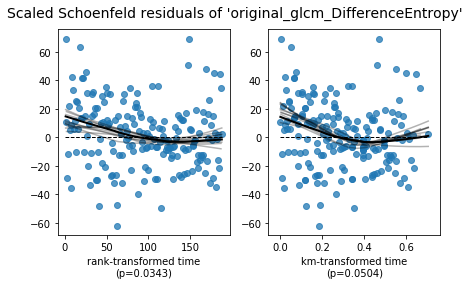

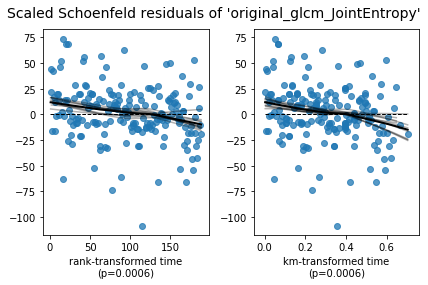

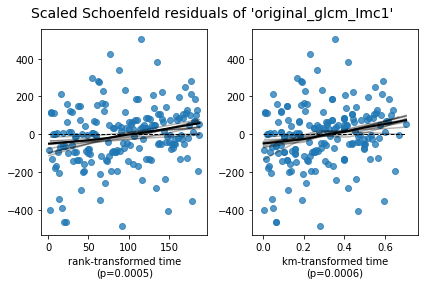

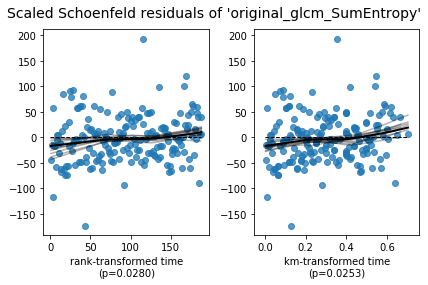

In [1352]:
cph.check_assumptions(clinicalRadioMerged, p_value_threshold=0.05, show_plots=True)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'original_glrlm_LongRunEmphasis' failed the non-proportional test: p-value is 0.0477.

   Advice 1: the functional form of the variable 'original_glrlm_LongRunEmphasis' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'original_glrlm_LongRunEmphasis' using pd.cut, and then
specify it in `strata=['original_glrlm_LongRunEmphasis', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifel

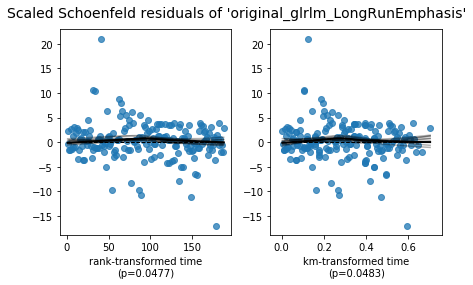

In [1353]:
##Remove the co-variable which have a neutral impact = exp(coef) = 1.00 and thos involving a violation.
clinicalRadioMerged.drop(["original_glcm_DifferenceEntropy", "original_glcm_JointEntropy",
                            "original_glcm_Imc1", "original_glcm_SumEntropy"], axis = 1, inplace=True)
cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)
cph.check_assumptions(clinicalRadioMerged, p_value_threshold=0.05, show_plots=True)

In [1354]:
##Remove the co-variables which have a neutral impact = exp(coef) = 1.00 and those involving a violation.
clinicalRadioMerged.drop(["original_firstorder_Skewness","original_glcm_Contrast",
                           "original_glcm_SumAverage","original_glrlm_LongRunEmphasis"], axis = 1, inplace=True)
cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)
cph.check_assumptions(clinicalRadioMerged, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


#### Data Analysis

As shown above, the "Proportional hazard assumption looks okay." and some covariables starting to have a high statistically significant on coefficient.
We can refit the model by skipping the ones having an huge higher p-value and continue to adjust the model until all covariates selected are statistically significant.


In [1355]:
## Drop the ones with p-value extremely >0.05
clinicalRadioMerged.drop(["original_glcm_Correlation","original_glcm_DifferenceAverage",
                          "original_glcm_Id","original_glcm_Idm", "original_glcm_Idmn",
                          "original_glcm_Idn"], axis = 1, inplace=True)
cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)

cph.check_assumptions(clinicalRadioMerged, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


In [1356]:
clinicalRadioMerged.drop(["original_shape_SurfaceVolumeRatio","original_glcm_InverseVariance",
                          "original_glcm_MaximumProbability","original_glrlm_ShortRunEmphasis",
                          "original_glrlm_ShortRunLowGrayLevelEmphasis"], axis = 1, inplace=True)
cph.fit(clinicalRadioMerged, 'SurvivalTime', 'Event')
cph.print_summary(decimals=3)

cph.check_assumptions(clinicalRadioMerged, p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


### Data Analysis

From this summary above, we can read that, individual treated from the L1 source and individuals with a higher homogeneous patterns and higher homogeneity and distribution of runs of an image (**sourceDataset_l2**, **glcm_JointEnergy** and **glrlm_RunPercentage**), are associated with better survival and those factors decrease the probability of occurrence of the event. 

On the contrary, the neighboring lymph nodes (regional) involved advanced and a higher randomness in the pixel values of the image (**Nstage**, and **firstorder_Entropy**) are associated with a higher risk of event and these factors increase the probability of occurrence of the event. So a poorer survival time.

At last, a greater heterogeneity of the image array, (**firstorder_Uniformity**) mean an high risk of event but this factor decrease the probability of occurrence of the event. It can be a good prognostic factor.

In [1357]:
clinicalRadioMerged.head()

,SurvivalTime,Event,Nstage,SourceDataset_l2,original_firstorder_Entropy,original_firstorder_Uniformity,original_glcm_JointEnergy,original_glrlm_RunPercentage
0,1378,0,0,1,5.138062382118321,0.037008423161283735,0.005919558920335507,0.8913295337029291
1,379,1,2,0,4.461053722332744,0.08006130804274754,0.02553211184702079,0.7660321748303586
2,573,1,3,0,3.437110589654181,0.1609050014904606,0.06656941447974507,0.6445541733928403
3,959,0,2,0,4.3525641618756525,0.07447606052451713,0.015048432154693049,0.8281380543886281
4,2119,0,3,0,4.055700408847022,0.10441884901082733,0.029316576238273537,0.7348979775536406


### Predict the survival time of a patient

Now that we have adjust train our model, we will use it on new sample of patients to predict their survival time.  
To start, we must to retrieve our data test.

In [1358]:


## Getting the features training directory
dirTest = Path.cwd() / "data-test\\features"
if not dirTest.exists():
    raise FileNotFoundError("The " + str(dirTest) + " path does not exist") 
if not dirTest.is_dir():
    raise FileNotFoundError("The " + str(dirTest) + "path is not a directory") 

# Getting the clinical file and read it in a dataframe 
clinicalFileTest = dirTest / "clinical_data.csv"
if not clinicalFileTest.exists():
    raise FileNotFoundError("The " + str(clinicalFileTest)+ " file does not exist") 
xClinicalTest = pd.read_csv(clinicalFileTest)

xClinicalTest_dummy = pd.get_dummies(xClinicalTest, drop_first=True)
xClinicalTest_dummy.info()
xClinicalTest_dummy.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 12 columns):
PatientID                                        125 non-null int64
Mstage                                           125 non-null int64
Nstage                                           125 non-null int64
Tstage                                           125 non-null int64
age                                              121 non-null float64
Histology_NSCLC NOS (not otherwise specified)    125 non-null uint8
Histology_Squamous cell carcinoma                125 non-null uint8
Histology_adenocarcinoma                         125 non-null uint8
Histology_large cell                             125 non-null uint8
Histology_nos                                    125 non-null uint8
Histology_squamous cell carcinoma                125 non-null uint8
SourceDataset_l2                                 125 non-null uint8
dtypes: float64(1), int64(4), uint8(7)
memory usage: 5.9 KB


,PatientID,Mstage,Nstage,Tstage,age,Histology_NSCLC NOS (not otherwise specified),Histology_Squamous cell carcinoma,Histology_adenocarcinoma,Histology_large cell,Histology_nos,Histology_squamous cell carcinoma,SourceDataset_l2
0,13,0,0,4,44.3970,0,0,0,0,1,0,0
1,155,0,3,1,63.3183,0,0,1,0,0,0,0
2,404,0,2,2,64.7255,0,0,0,1,0,0,0
3,407,0,0,2,65.3635,0,0,0,0,1,0,0
4,9,0,0,2,50.0000,0,0,0,0,0,0,1


In [1359]:
radiomicsFileTest = dirTest / "radiomics.csv"
if not radiomicsFileTest.exists():
    raise FileNotFoundError("The " + str(radiomicsFileTest)+ " file does not exist") 

xRadiomicsTest = pd.read_csv(radiomicsFileTest)
xRadiomicsTest.head()


,Unnamed: 0,shape,shape.1,shape.2,shape.3,shape.4,shape.5,shape.6,shape.7,firstorder,...,textural.21,textural.22,textural.23,textural.24,textural.25,textural.26,textural.27,textural.28,textural.29,textural.30
0,NaN,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
1,PatientID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,013,0.02888521807913762,0.2964514286695039,106.90182411914213,1.4997383054588147,0.6667829956467439,29085.541425363514,0.11452777845917761,254069.0,2006942430.0,...,5.786838511970755,21219.447221119444,64776.69757926393,0.5670945839364655,0.0014934974903616607,808.353957091605,0.0010936026706116241,554.1119978588921,0.007534740404869377,4654.031975617358
3,155,0.03194837238720588,0.36266005403772866,18.81488772222678,1.402275757481352,0.7131264978837789,629.44364000626,0.7038788258387029,911.0,262393816.0,...,1.1603967538271833,25.291607680973797,795.6752799214078,0.9534746263615637,0.011646089610174305,548.9645727442402,0.010835520680564275,529.6440291417058,0.01563269704193925,639.6219629172265
4,404,0.015998834925719053,0.0909450279994979,105.08092119885512,2.223687115406422,0.4497035545476147,12509.265443769824,0.3152976995595148,39809.0,665032231.0,...,4.064385250880343,3225.8083324725712,14007.50928452286,0.6442474353499499,0.0011709310388930345,1600.9522654535785,0.001003034008071181,1181.3777735448612,0.003026516852404476,7156.937666524343


In [1360]:
## Reajust to get a suitable data frame 
xRadiomicsTest.drop(["Unnamed: 0"], axis=1, inplace=True)
xRadiomicsTest.head()
firstRow = xRadiomicsTest.loc[0,:]
firstRow
xRadiomicsTest.columns = firstRow

xRadiomicsTest.drop([0,1], inplace=True)
xRadiomicsTest.reset_index(drop=True,inplace=True)
xRadiomicsTest.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,0.02888521807913762,0.2964514286695039,106.90182411914213,1.4997383054588147,0.6667829956467439,29085.541425363514,0.11452777845917761,254069.0,2006942430.0,3.073901204913679,...,5.786838511970755,21219.447221119444,64776.69757926393,0.5670945839364655,0.0014934974903616607,808.353957091605,0.0010936026706116241,554.1119978588921,0.007534740404869377,4654.031975617358
1,0.03194837238720588,0.36266005403772866,18.81488772222678,1.402275757481352,0.7131264978837789,629.44364000626,0.7038788258387029,911.0,262393816.0,5.206990174813962,...,1.1603967538271833,25.291607680973797,795.6752799214078,0.9534746263615637,0.011646089610174305,548.9645727442402,0.010835520680564275,529.6440291417058,0.01563269704193925,639.6219629172265
2,0.015998834925719053,0.0909450279994979,105.08092119885512,2.223687115406422,0.4497035545476147,12509.265443769824,0.3152976995595148,39809.0,665032231.0,3.2623265669273813,...,4.064385250880343,3225.8083324725712,14007.50928452286,0.6442474353499499,0.0011709310388930345,1600.9522654535785,0.001003034008071181,1181.3777735448612,0.003026516852404476,7156.937666524343
3,0.031357660885439724,0.3493731813120354,46.968074263269514,1.419831515538599,0.7043089190907696,4067.6573722770927,0.28210398587121804,14458.0,375428731.0,3.5898612979729365,...,2.902585983552506,1147.928169625991,6094.8055835410405,0.7114666354533556,0.0021042753512783884,1533.2177880035028,0.0018997254630333837,1182.8763633701415,0.003685003163801367,4776.549407884615
4,0.017814538285697575,0.1127590447058208,56.542019772908716,2.069900823752435,0.4831149340706782,7093.365689658921,0.37603157853867447,18942.0,9108915274.0,5.067417641320739,...,1.195504779594246,652.0713671481254,15924.101510304838,0.942025454220576,0.01928124971242974,344.20578608557054,0.01822101655661966,331.90121216251634,0.024175162483351866,400.01584748374046


In [1361]:
## concqt the two data frames
clinicalRadioMergedTest = pd.concat([xClinicalTest_dummy, xRadiomicsTest], axis=1).reindex(xClinicalTest_dummy.index)
clinicalRadioMergedTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 65 columns):
PatientID                                        125 non-null int64
Mstage                                           125 non-null int64
Nstage                                           125 non-null int64
Tstage                                           125 non-null int64
age                                              121 non-null float64
Histology_NSCLC NOS (not otherwise specified)    125 non-null uint8
Histology_Squamous cell carcinoma                125 non-null uint8
Histology_adenocarcinoma                         125 non-null uint8
Histology_large cell                             125 non-null uint8
Histology_nos                                    125 non-null uint8
Histology_squamous cell carcinoma                125 non-null uint8
SourceDataset_l2                                 125 non-null uint8
original_shape_Compactness1                      125 non-null object
original

In [1364]:
## Call to predict_mean() method to predict new survival time in days for each patient
## The result is infinity when the survival curve of the individual does not cross 0.5. (50%)
yTestDf = cph.predict_median(clinicalRadioMergedTest)
yTestDf.rename(columns={0.5: "SurvivalTime"},inplace=True)
yTestDf["Event"] = np.nan
yTestDf.index = xClinicalTest["PatientID"]
yTestDf.head()

,SurvivalTime,Event
PatientID,,
13,426.0,NaN
155,991.0,NaN
404,515.0,NaN
407,635.0,NaN
9,inf,NaN


In [1365]:
filename =  dirTest.parent / "yTeskt.csv"
yTestDf.to_csv(filename, na_rep='NaN')
print("Writing process complete.")

Writing process complete.
